#Demo de TF-Agents para ejemplo del Mono que quiere Banana usando DQN:
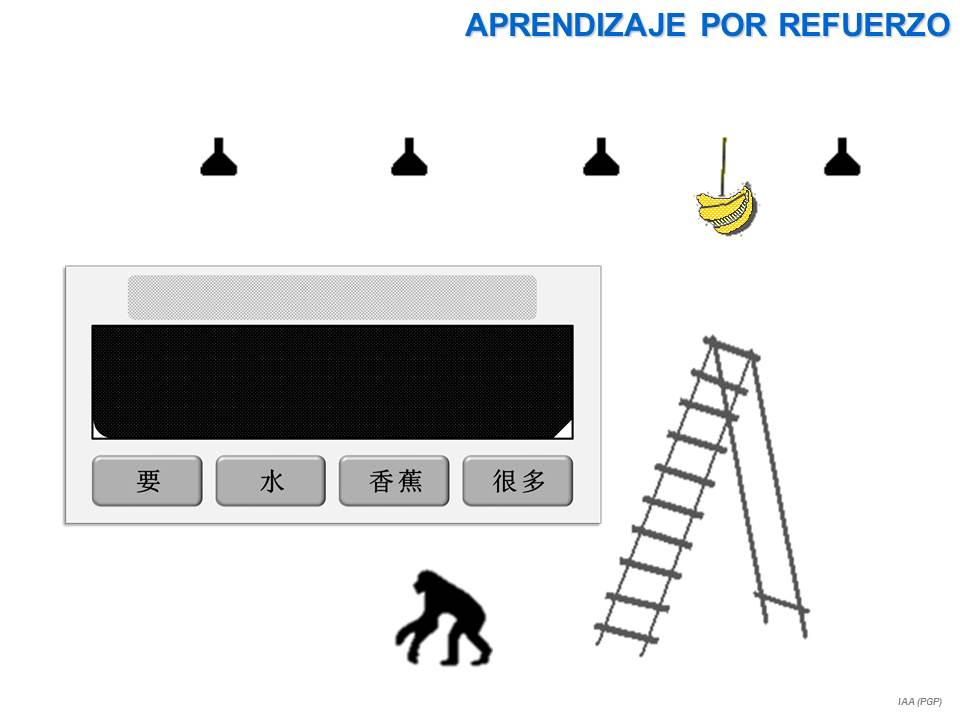

0) Preparar el ambiente:

In [1]:
#@title Instalar Paquete de TF-Agents
!pip install -q tf-agents
print("TF-Agentes instalado.")

     |████████████████████████████████| 1.2MB 5.9MB/s 
TF-Agentes instalado.


In [2]:
#@title Cargar Librerías
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment

from tf_agents.environments import utils
from tf_agents.specs import array_spec

from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")

Librerías cargadas.


1) Establecer las clases del Problema y del Agente:

Entorno del Problema:

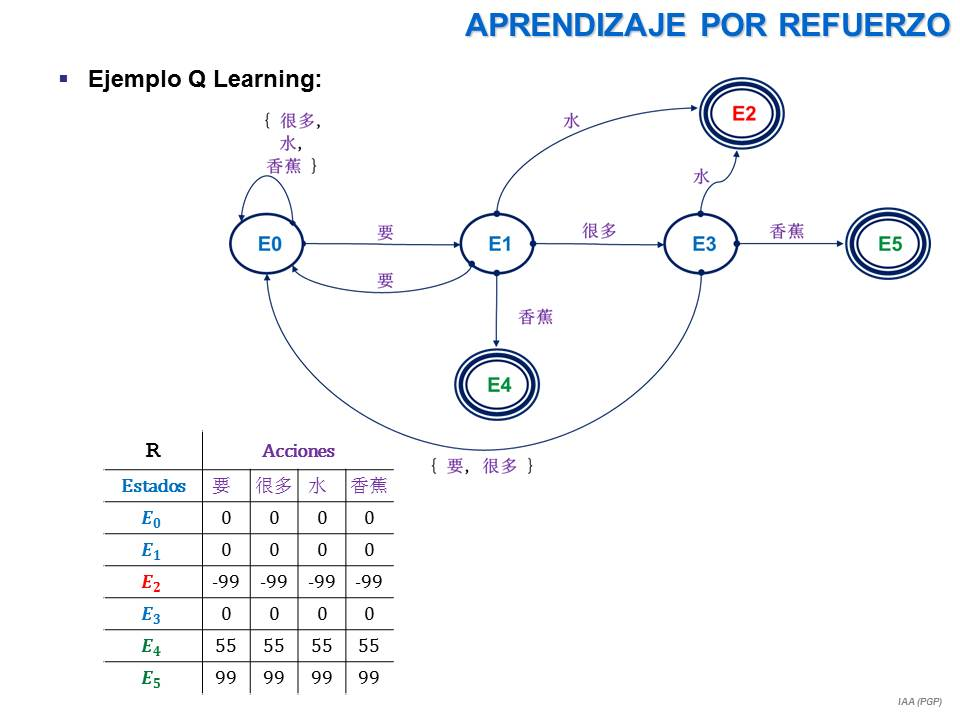


In [3]:
#@title Definir Entorno del Problema 

# variable auxiliar para determinar máximo de acciones a probar antes de abortar
MAX_ACCIONES_REALIZAR = 25
# variables auxiliares para determinar Acciones
posiblesAcciones = [ '要', '水', '香蕉', '很多' ]
posiblesAccionesDescrip = [ 'QUIERO', 'AGUA', 'BANANA', 'MUCHA' ]
# variables auxiliares para determinar Estados, con sus recompensas y sus transiciones posibles
# como a la recompensa lo penaliza la cantidad de iteraciones, 
#   en los estados finales se suma la cantidad mínima para que quede bien si es óptimo
matrizEstados = []
## E0
matrizEstados.append( { 'FINAL': False, 'REWARD': 0, '要' : 1, '水' : 0, '香蕉' : 0, '很多' : 0 } )
## E1
matrizEstados.append( { 'FINAL': False, 'REWARD': 0,  '要' : 0, '水' : 2, '香蕉' : 4, '很多' : 3 } )
## E2 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (-99 + 1),  '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )
## E3
matrizEstados.append( { 'FINAL': False, 'REWARD': 0, '要' : 0, '水' : 2, '香蕉' : 5, '很多' : 0 } )
## E4 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (55 + 1), '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )
## E5 (estado final)
matrizEstados.append( { 'FINAL': True, 'REWARD': (99 + 2), '要' : -1, '水' : -1, '香蕉' : -1, '很多' : -1 } )

# Un entorno que represente el juego podría verse así:
class ExperimentoMonoEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=len(posiblesAcciones)-1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(2,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def _reset(self):
    # resetea el entorno
    self._state = 0
    self._cantIteraciones = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state, -1], dtype=np.int32))

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()
    
    if action < 0 or action > len(posiblesAcciones):
      raise ValueError("ID de acción inválida ", action,"!")

    # Aplica la acción correspondiente
    accionTipo = posiblesAcciones[action]
    if accionTipo in matrizEstados[self._state]:
        self._state = matrizEstados[self._state][accionTipo]
    else:      
      raise ValueError("Tipo de acción inválida: ", accionTipo,"!")

    # determina si debe finalizar o no
    if (self._state < 0) or (abs(self._cantIteraciones) >= abs(MAX_ACCIONES_REALIZAR)):
      # llegó a un estado inválido,
      # o si la cantidad de iteraciones llega al límite
      # fuerza que finaliza
      self._episode_ended = True
    else:
      # llegó a un estado final
      self._episode_ended =  matrizEstados[self._state]["FINAL"]

    if self._episode_ended:
      # si finaliza
      # devuelve el reward (siempre se maximiza)
      reward = matrizEstados[self._state]["REWARD"] + self._cantIteraciones
      return ts.termination(np.array([self._state, reward], dtype=np.int32), reward)
    else:
      # si no finaliza
      self._cantIteraciones = self._cantIteraciones - 1
      return ts.transition(
          np.array([self._state, 0], dtype=np.int32), reward=self._cantIteraciones, discount=0.9)

print("Entorno del Problema definido.")

# Definir entornos de entrenamiento y evaluación
train_py_env = ExperimentoMonoEnv()
eval_py_env = ExperimentoMonoEnv()

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("Entornos de entrenamiento y prueba definidos. ")

# definir simulador para probar el entorno
def SimularEntorno(eval_env, policy, titulo):
    print("\n** ", titulo, "**")                   
    # muesta estado inicial
    time_step = eval_env.reset()  
    ob = time_step.observation.numpy()[0]
    print(" Ini: estado ", ob[0], "[", time_step, "]")      
    j = 1
    secuenciaAcciones = ""
    while not time_step.is_last():
      # la política determina la acción a realizar
      action_step = policy.action( time_step )
      time_step = eval_env.step( action_step.action )
      # recupera la observación y muestra el nuevo estado
      ac = action_step.action.numpy()[0]
      ob = time_step.observation.numpy()[0]
      descAccion = "acción " + posiblesAcciones[ ac ] 
      if j > 1:
        secuenciaAcciones = secuenciaAcciones + " + "
      secuenciaAcciones = secuenciaAcciones + posiblesAccionesDescrip[ ac ]
      print(" #", j, ": ", descAccion, "-> Estado ", ob[0], "[", time_step, "]")
      j = j + 1

    # muestra estado final
    ob = time_step.observation.numpy()[0]
    r = time_step.reward.numpy()
    print(" Fin -> Estado ", ob[0], "[", time_step, "]")
    print(" Secuencia de Acciones = ", secuenciaAcciones)
    print(' Recompensa Final = ', r[0])
    return r[0]

print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}

if Probar_Entorno:
  SimularEntorno(eval_env, random_policy, "Probando el entorno del problema al azar")


Entorno del Problema definido.
Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema al azar **
 Ini: estado  0 [ TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[ 0, -1]], dtype=int32)>) ]
 # 1 :  acción 水 -> Estado  0 [ TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>, observation=<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 0]], dtype=int32)>) ]
 # 2 :  acción 要 -> Estado  1 [ TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1]

In [4]:
#@title Definir el Agente tipo DQN

learning_rate = 1e-3  # @param {type:"number"}
cant_neuronas_ocultas = 100 # @param {type:"integer"}
if cant_neuronas_ocultas < 10:
  cant_neuronas_ocultas = 10

# Define cantidad de neuronas ocultas para RNA-Q
fc_layer_params = (cant_neuronas_ocultas,)

# Define RNA-Q
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

# Define el agente de tipo Q
ag = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

ag.initialize()

# define política para evaluación para el Agente
eval_policy = ag.policy

# define política para recolección de datos para el Agente
collect_policy = ag.collect_policy

print("Agente DQN inicializado. ")

Agente DQN inicializado. 


In [5]:
#@title Definir Métricas para evaluación

# Se usa el promedio de la recompensa (la más común)
# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

print("Métricas definidas.")

Métricas definidas.


3) Llevar a cabo el Entrenamiento:

In [6]:
#@title Preparar datos para Entrenamiento

initial_collect_steps =   1000# @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 64  # @param {type:"integer"}


# Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = ag.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)

# Recolecta datos generados al azar
# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

print("\nDatos recolectados.")

# Muestra ejemplo de los datos recolectados
##iter(replay_buffer.as_dataset()).next()

# Preparar los datos recolectados con trajectories de shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
iterator = iter(dataset)
# Muestra ejemplo 
##iterator.next()
print("\nDataset creado.")


Datos recolectados.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.

Dataset creado.


In [7]:
#@title Entrenar al Agente

cant_ciclos_entrenamiento = 5000 # @param {type:"integer"}
log_cada_ciclos = 200  # @param {type:"integer"}
evaluar_cada_ciclos = 1000  # @param {type:"integer"}
cant_episodios_evaluacion = 25  # @param {type:"integer"}


#  Optimize by wrapping some of the code in a graph using TF function (Optional)
ag.train = common.function(ag.train)

# Reset the train step
ag.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
ar_ciclo = []
ar_returns = []
ar_loss = []

print("\n** Comienza el Entrenamiento **\n")
for _ in range(cant_ciclos_entrenamiento):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, ag.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = ag.train(experience).loss

  step = ag.train_step_counter.numpy()

  if (step == 1) or (step % log_cada_ciclos == 0):
    print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
    ar_ciclo.append( step )
    ar_loss.append( train_loss )
    avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
    ar_returns.append( avg_return )

    if (step == 1) or (step % evaluar_cada_ciclos == 0):
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

print("\n** Entrenamiento Finalizado **\n")



** Comienza el Entrenamiento **

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1: loss = 904.888
step = 1: Promedio Recompensa = -350.0
step = 200: loss = 430.298
step = 400: loss = 375.425
step = 600: loss = 463.044
step = 800: loss = 520.219
step = 1000: loss = 367.147
step = 1000: Promedio Recompensa = 54.0
step = 1200: loss = 79.112
step = 1400: loss = 145.929
step = 1600: loss = 243.833
step = 1800: loss = 159.382
step = 2000: loss = 57.827
step = 2000: Promedio Recompensa = 54.0
step = 2200: loss = 92.122
step = 2400: loss = 7.693
step = 2600: loss = 67.392
step = 2800: loss = 96.313
step = 3000: loss = 159.554
step = 3000: Promedio Recompensa = 96.0
step = 3200: loss = 35.625
step = 3400: loss = 67.820
step = 3600: loss = 42.827
step = 3800: loss = 22.433
step = 4000: loss = 81.819
step

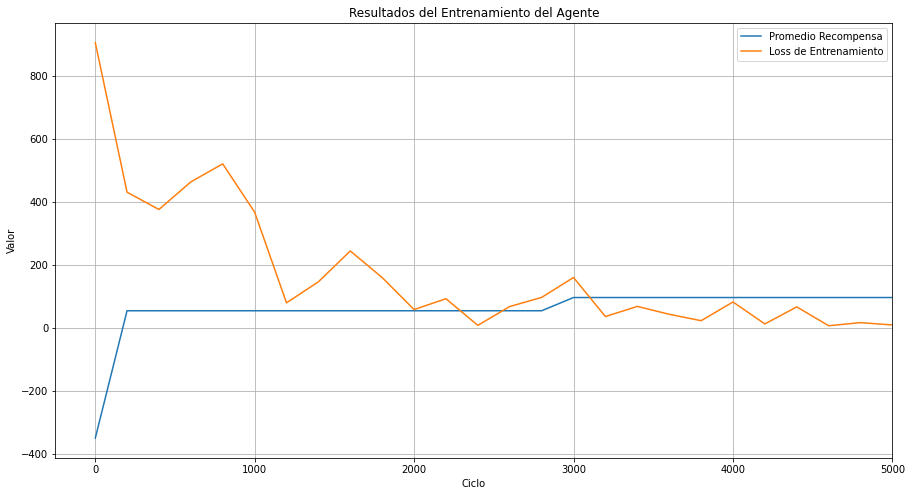

In [8]:
#@title Mostrar Gráficos del Entrenamiento

plt.figure(figsize=(15,8)) 
plt.plot( ar_ciclo, ar_returns)
plt.plot( ar_ciclo, ar_loss )
plt.title("Resultados del Entrenamiento del Agente")
plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
plt.ylabel('Valor')
plt.xlabel('Ciclo')
plt.xlim(right=max(ar_ciclo))   
##plt.ylim(top=21)    
plt.grid(True)
plt.show()


4) Probar entrenamiento comparando resultados:

In [9]:
#@title Probar el Agente Entrenado contra el Azar
cantidad_probar = 5 # @param {type:"integer"}
promAzar = 0
promAgente = 0

for i in range(cantidad_probar):

  print("\n> Prueba ", i+1, ":")

  # Probar Aleatorio
  valorAzar = SimularEntorno(eval_env, random_policy, "Resultados Aleatorio") 
  promAzar = promAzar + valorAzar

  # Probar Agente Entrenado
  valorAgente = SimularEntorno(eval_env, ag.policy, "Resultados de Agente Entrenado") 
  promAgente = promAgente + valorAgente

  # Decide Ganador
  if valorAzar < valorAgente:
    print("\n--> El Agente Entrenado (", valorAgente,") genera MEJOR resultado que el azar (", valorAzar,")")
  else:
    print("\n--> El Agente Entrenado (", valorAgente,") genera PEOR resultado que el azar (", valorAzar,")")


# Decide Ganador General
if cantidad_probar > 0:
  promAgente = promAgente / cantidad_probar
  promAzar = promAzar / cantidad_probar
  print("\n================================================================================================\n")
  if promAzar < promAgente:
    print("= En promedio, el Agente Entrenado (", promAgente,") tiene MEJORES resultado que  el azar (", promAzar,")")
  else:
    print("= En promedio, el Agente Entrenado (", promAgente,") tiene PEORES resultados que el azar (", promAzar,")")
  print("\n================================================================================================\n")


> Prueba  1 :

**  Resultados Aleatorio **
 Ini: estado  0 [ TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[ 0, -1]], dtype=int32)>) ]
 # 1 :  acción 很多 -> Estado  0 [ TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>, observation=<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 0]], dtype=int32)>) ]
 # 2 :  acción 水 -> Estado  0 [ TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.], dtype=float32)>, discount=<tf.Te